In [122]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt

# Step 1: Load the combined dataset
file_path = "combined_data.csv"  # Update with your actual file path
data = pd.read_csv(file_path)

# Step 1: Identify feature and label columns
feature_columns = [col for col in data.columns if 'raw_' in col]
label_columns = [col for col in data.columns if 'label:' in col]

# Step 2: Remove feature columns with excessive NaN values
feature_threshold = 0.25  # Adjust the threshold for features as needed
feature_nan_percentage = data[feature_columns].isna().mean()
filtered_features = data[feature_columns].loc[:, feature_nan_percentage < feature_threshold]

# Debug: Check the number of features remaining
print(f"Features remaining after filtering: {filtered_features.shape[1]}")

# Step 3: Remove label columns with excessive NaN values
label_threshold = 0.40  # Adjust the threshold for labels as needed
label_nan_percentage = data[label_columns].isna().mean()
filtered_labels = data[label_columns].loc[:, label_nan_percentage < label_threshold]

# Debug: Check the number of labels remaining
print(f"Labels remaining after filtering: {filtered_labels.shape[1]}")

# Step 4: Combine filtered features and labels
cleaned_data = pd.concat([filtered_features, filtered_labels], axis=1)

# Step 5: Remove rows with any remaining NaN values
cleaned_data = cleaned_data.dropna()  # Drop rows where any column (features or labels) has NaN

# Debug: Check remaining rows and columns
print(f"Remaining rows after dropping all NaN rows: {cleaned_data.shape[0]}")

# Step 6: Separate features and labels for model input
features = cleaned_data[filtered_features.columns]
labels = cleaned_data[filtered_labels.columns]

# Debug: Final dataset overview
print("Final dataset info:")
print(cleaned_data.info())

Features remaining after filtering: 57
Labels remaining after filtering: 12
Remaining rows after dropping all NaN rows: 81463
Final dataset info:
<class 'pandas.core.frame.DataFrame'>
Index: 81463 entries, 2287 to 334109
Data columns (total 69 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   raw_acc:magnitude_stats:mean                        81463 non-null  float64
 1   raw_acc:magnitude_stats:std                         81463 non-null  float64
 2   raw_acc:magnitude_stats:moment3                     81463 non-null  float64
 3   raw_acc:magnitude_stats:moment4                     81463 non-null  float64
 4   raw_acc:magnitude_stats:percentile25                81463 non-null  float64
 5   raw_acc:magnitude_stats:percentile50                81463 non-null  float64
 6   raw_acc:magnitude_stats:percentile75                81463 non-null  float64
 7   raw_acc:magn

In [123]:
data = cleaned_data

In [124]:
# Check for NaN values in the dataset
nan_exists = data.isna().any().any()

if nan_exists:
    print("There are NaN values in the dataset.")
    
    # Display the count of NaN values in each column
    nan_columns = data.isna().sum()
    print("Columns with NaN values and their counts:\n", nan_columns[nan_columns > 0])
else:
    print("The dataset is free of NaN values.")

The dataset is free of NaN values.


In [125]:
# Step 1: Identify feature and label columns dynamically
feature_columns = [col for col in data.columns if not col.startswith('label:')]
label_columns = [col for col in data.columns if col.startswith('label:')]

print("Features used for training:", feature_columns)
print("Labels used for training:", label_columns)

# Step 2: Split data into features and labels
features = data[feature_columns].values
labels = data[label_columns].values

# Step 3: Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42
)

# Proceed with scaling and model training...

Features used for training: ['raw_acc:magnitude_stats:mean', 'raw_acc:magnitude_stats:std', 'raw_acc:magnitude_stats:moment3', 'raw_acc:magnitude_stats:moment4', 'raw_acc:magnitude_stats:percentile25', 'raw_acc:magnitude_stats:percentile50', 'raw_acc:magnitude_stats:percentile75', 'raw_acc:magnitude_stats:value_entropy', 'raw_acc:magnitude_stats:time_entropy', 'raw_acc:magnitude_spectrum:log_energy_band0', 'raw_acc:magnitude_spectrum:log_energy_band1', 'raw_acc:magnitude_spectrum:log_energy_band2', 'raw_acc:magnitude_spectrum:log_energy_band3', 'raw_acc:magnitude_spectrum:log_energy_band4', 'raw_acc:magnitude_spectrum:spectral_entropy', 'raw_acc:magnitude_autocorrelation:period', 'raw_acc:magnitude_autocorrelation:normalized_ac', 'raw_acc:3d:mean_x', 'raw_acc:3d:mean_y', 'raw_acc:3d:mean_z', 'raw_acc:3d:std_x', 'raw_acc:3d:std_y', 'raw_acc:3d:std_z', 'raw_acc:3d:ro_xy', 'raw_acc:3d:ro_xz', 'raw_acc:3d:ro_yz', 'raw_magnet:magnitude_stats:mean', 'raw_magnet:magnitude_stats:std', 'raw_mag

In [126]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Step 1: Split the data into features and labels
features = data[feature_columns].values
labels = data[label_columns].values

# Step 2: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42
)

# Step 3: Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 4: Build the neural network model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(labels.shape[1], activation='sigmoid')  # Use sigmoid for multi-label classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 5: Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

# Step 6: Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Step 7: Generate a classification report
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_columns))

Epoch 1/100


C:\Users\dagin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


815/815 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3046 - loss: 0.4096 - val_accuracy: 0.4518 - val_loss: 0.3052
Epoch 2/100
815/815 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4413 - loss: 0.3172 - val_accuracy: 0.5041 - val_loss: 0.2882
Epoch 3/100
815/815 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4740 - loss: 0.3004 - val_accuracy: 0.5339 - val_loss: 0.2756
Epoch 4/100
815/815 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5012 - loss: 0.2894 - val_accuracy: 0.5187 - val_loss: 0.2681
Epoch 5/100
815/815 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5131 - loss: 0.2821 - val_accuracy: 0.5632 - val_loss: 0.2616
Epoch 6/100
815/815 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5239 - loss: 0.2771 - val_accuracy: 0.5499 - val_loss: 0.2578
Epoch 7/100
815/815 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5285 - loss: 0.2710 - val_accuracy: 0.5609 - val_loss: 0.2534
Epoch 8/100
815/815 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5307 - loss: 0.2698 - val_accuracy: 0.5773

C:\Users\dagin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


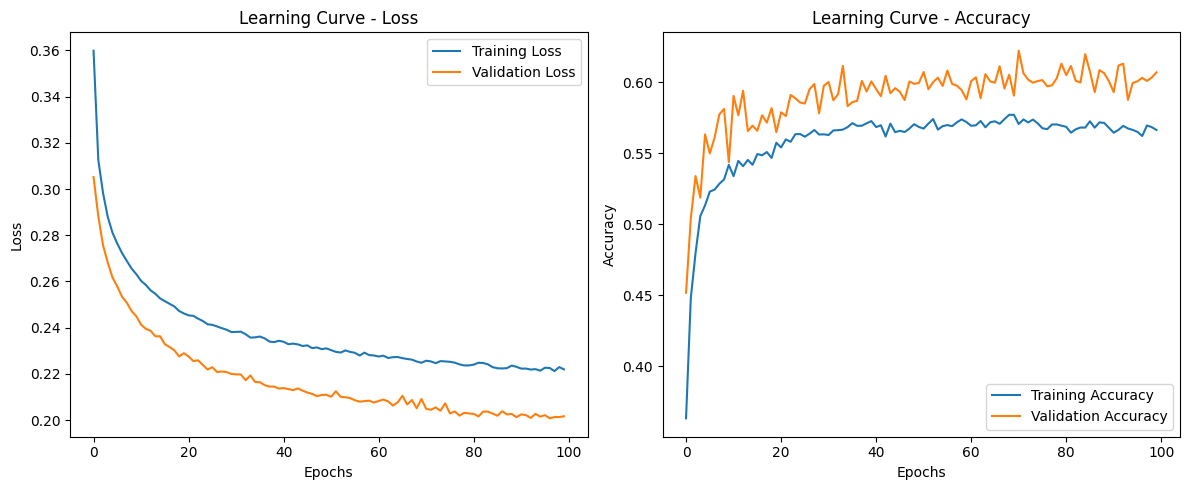

In [127]:
def plot_learning_curves(history):
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Learning Curve - Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Learning Curve - Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_learning_curves(history)

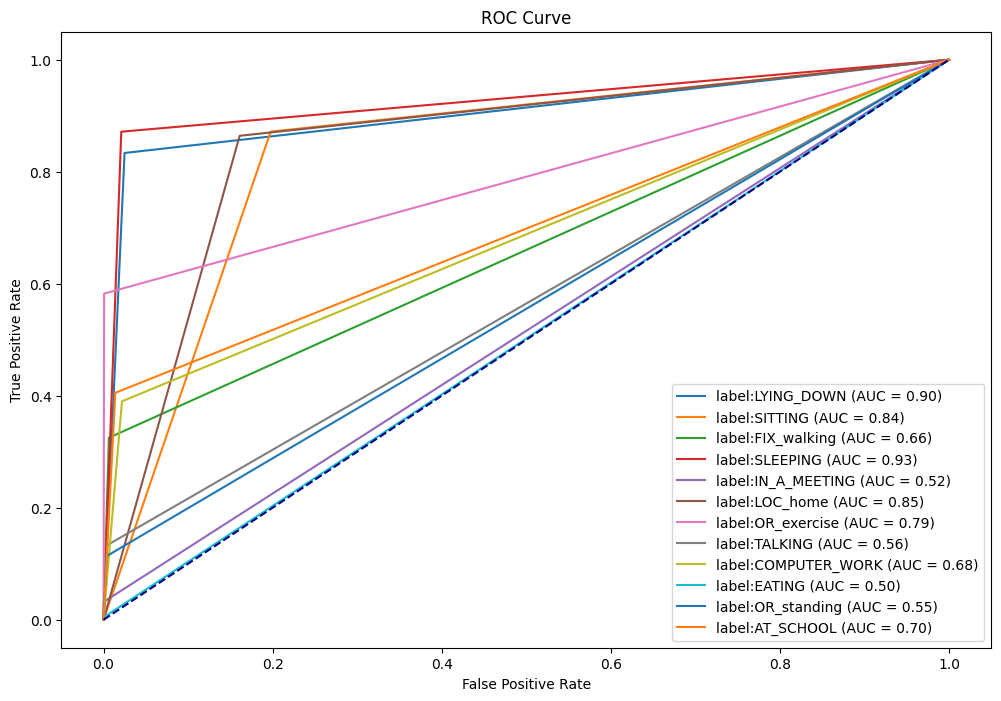

In [128]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curves(y_test, y_pred, label_columns):
    plt.figure(figsize=(12, 8))
    for i in range(len(label_columns)):
        fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{label_columns[i]} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

plot_roc_curves(y_test, y_pred, label_columns)

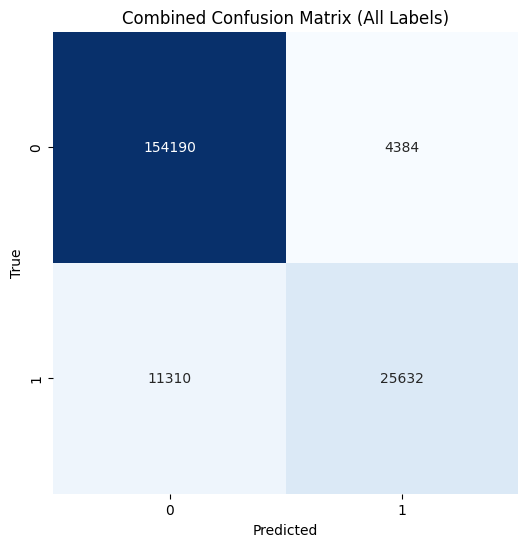

In [129]:
def plot_combined_confusion_matrix(y_test, y_pred, label_columns):
    # Initialize the combined confusion matrix
    combined_cm = np.zeros((2, 2), dtype=int)  # For binary classification per label

    # Sum up confusion matrices for each label
    for i in range(len(label_columns)):
        cm = confusion_matrix(y_test[:, i], y_pred[:, i])
        combined_cm += cm

    # Plot the combined confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(combined_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Combined Confusion Matrix (All Labels)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_combined_confusion_matrix(y_test, y_pred, label_columns)

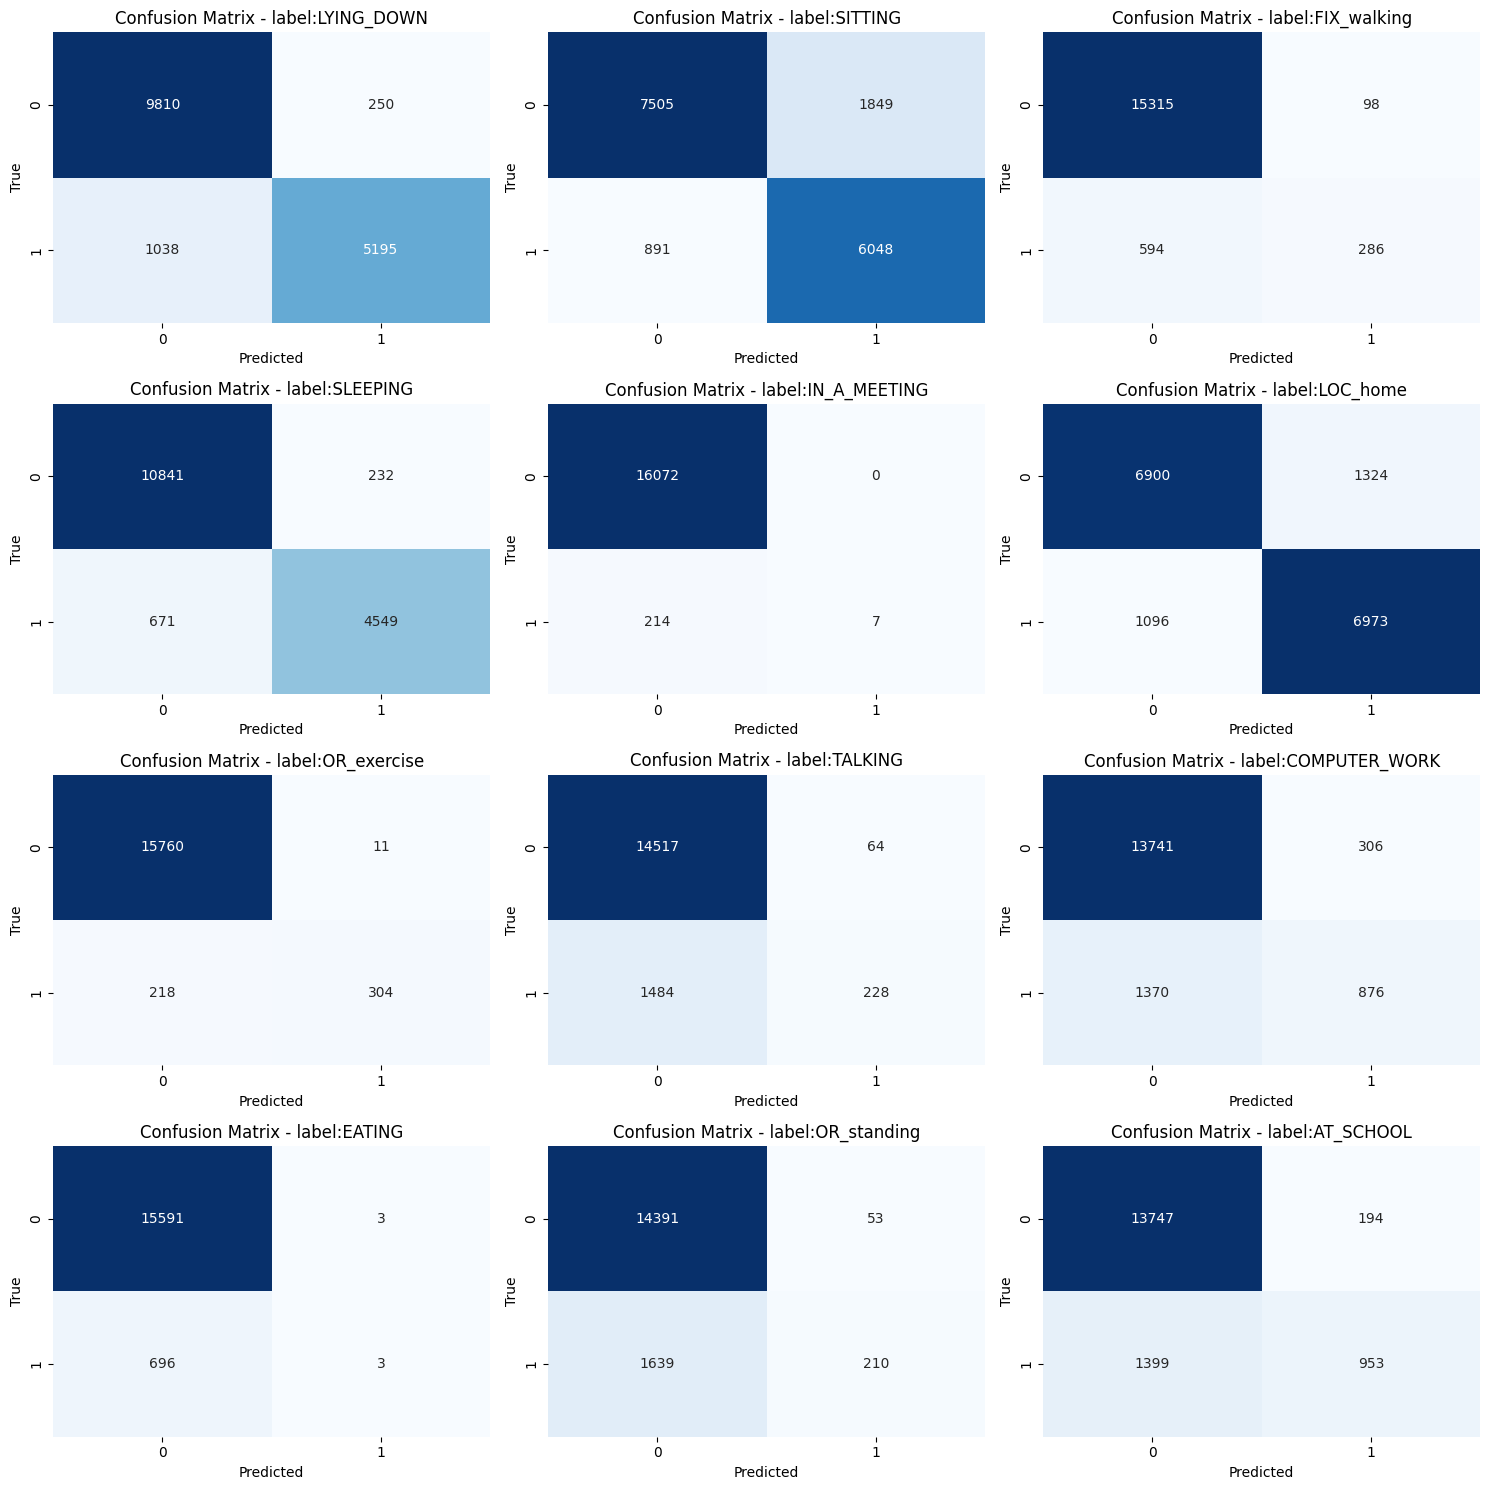

In [130]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

def plot_confusion_matrix(y_test, y_pred, label_columns):
    num_labels = len(label_columns)
    plt.figure(figsize=(15, 15))
    
    for i in range(num_labels):
        cm = confusion_matrix(y_test[:, i], y_pred[:, i])
        plt.subplot((num_labels + 2) // 3, 3, i + 1)  # Arrange subplots in grid
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Confusion Matrix - {label_columns[i]}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
    
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_test, y_pred, label_columns)

In [131]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Step 1: Split the data into features and labels
features = data[feature_columns].values
labels = data[label_columns].values

# Step 2: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42
)

# Step 3: Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 4: Calculate class weights for handling class imbalance
class_weights = {}
for i in range(labels.shape[1]):
    class_weights[i] = compute_class_weight(
        class_weight='balanced',
        classes=[0, 1],
        y=y_train[:, i]
    )
    class_weights[i] = dict(enumerate(class_weights[i]))

# Step 5: Build the neural network model with added complexity and batch normalization
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(labels.shape[1], activation='sigmoid')  # Use sigmoid for multi-label classification
])

# Compile the model with an Adam optimizer and a learning rate scheduler
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Step 6: Define callbacks for early stopping, model checkpointing, and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)  # Use .keras format
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Step 7: Train the model with class weights
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, checkpoint, lr_scheduler],
    verbose=1
)

# Step 8: Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Step 9: Generate predictions and calculate the F1 score
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate and display the F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1 Score: {f1}")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_columns))

Epoch 1/50


C:\Users\dagin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


815/815 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2775 - loss: 0.4525 - val_accuracy: 0.5117 - val_loss: 0.2983 - learning_rate: 0.0010
Epoch 2/50
815/815 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4366 - loss: 0.3165 - val_accuracy: 0.4938 - val_loss: 0.2822 - learning_rate: 0.0010
Epoch 3/50
815/815 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4564 - loss: 0.3002 - val_accuracy: 0.5359 - val_loss: 0.2708 - learning_rate: 0.0010
Epoch 4/50
815/815 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4751 - loss: 0.2881 - val_accuracy: 0.5130 - val_loss: 0.2632 - learning_rate: 0.0010
Epoch 5/50
815/815 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4955 - loss: 0.2811 - val_accuracy: 0.5305 - val_loss: 0.2591 - learning_rate: 0.0010
Epoch 6/50
815/815 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4901 - loss: 0.2760 - val_accuracy: 0.5442 - val_loss: 0.2519 - learning_rate: 0.0010
Epoch 7/50
815/815 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5021 - loss: 0.2704 - val_accurac

C:\Users\dagin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dagin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


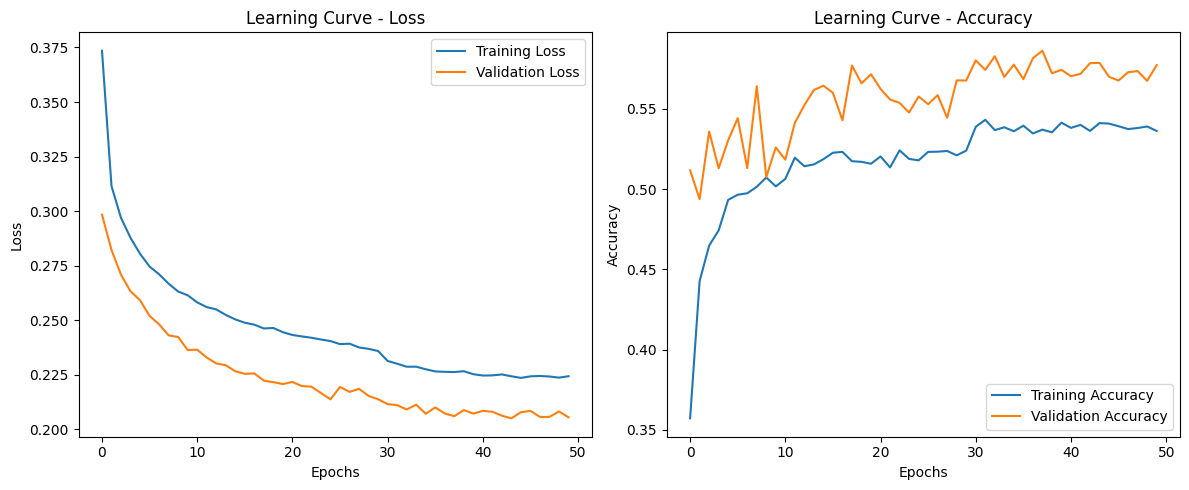

In [132]:
def plot_learning_curves(history):
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Learning Curve - Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Learning Curve - Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_learning_curves(history)

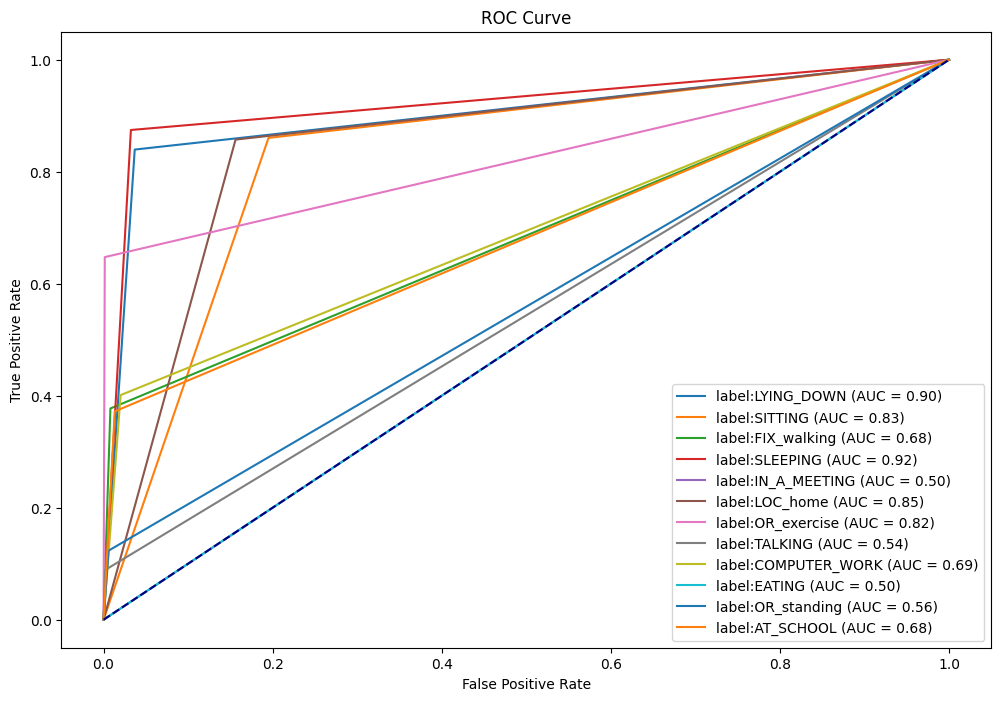

In [133]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curves(y_test, y_pred, label_columns):
    plt.figure(figsize=(12, 8))
    for i in range(len(label_columns)):
        fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{label_columns[i]} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

plot_roc_curves(y_test, y_pred, label_columns)

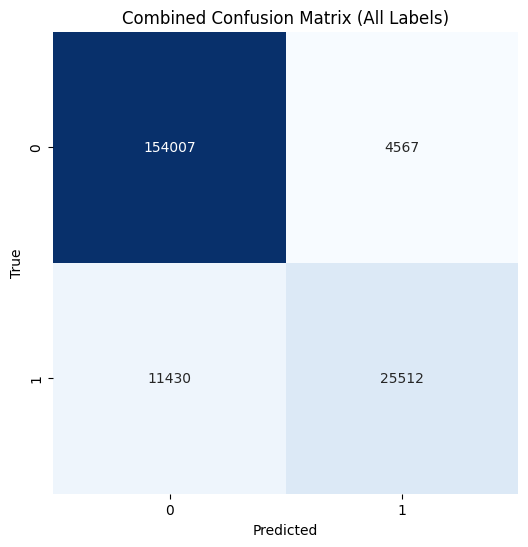

In [134]:
def plot_combined_confusion_matrix(y_test, y_pred, label_columns):
    # Initialize the combined confusion matrix
    combined_cm = np.zeros((2, 2), dtype=int)  # For binary classification per label

    # Sum up confusion matrices for each label
    for i in range(len(label_columns)):
        cm = confusion_matrix(y_test[:, i], y_pred[:, i])
        combined_cm += cm

    # Plot the combined confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(combined_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Combined Confusion Matrix (All Labels)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_combined_confusion_matrix(y_test, y_pred, label_columns)

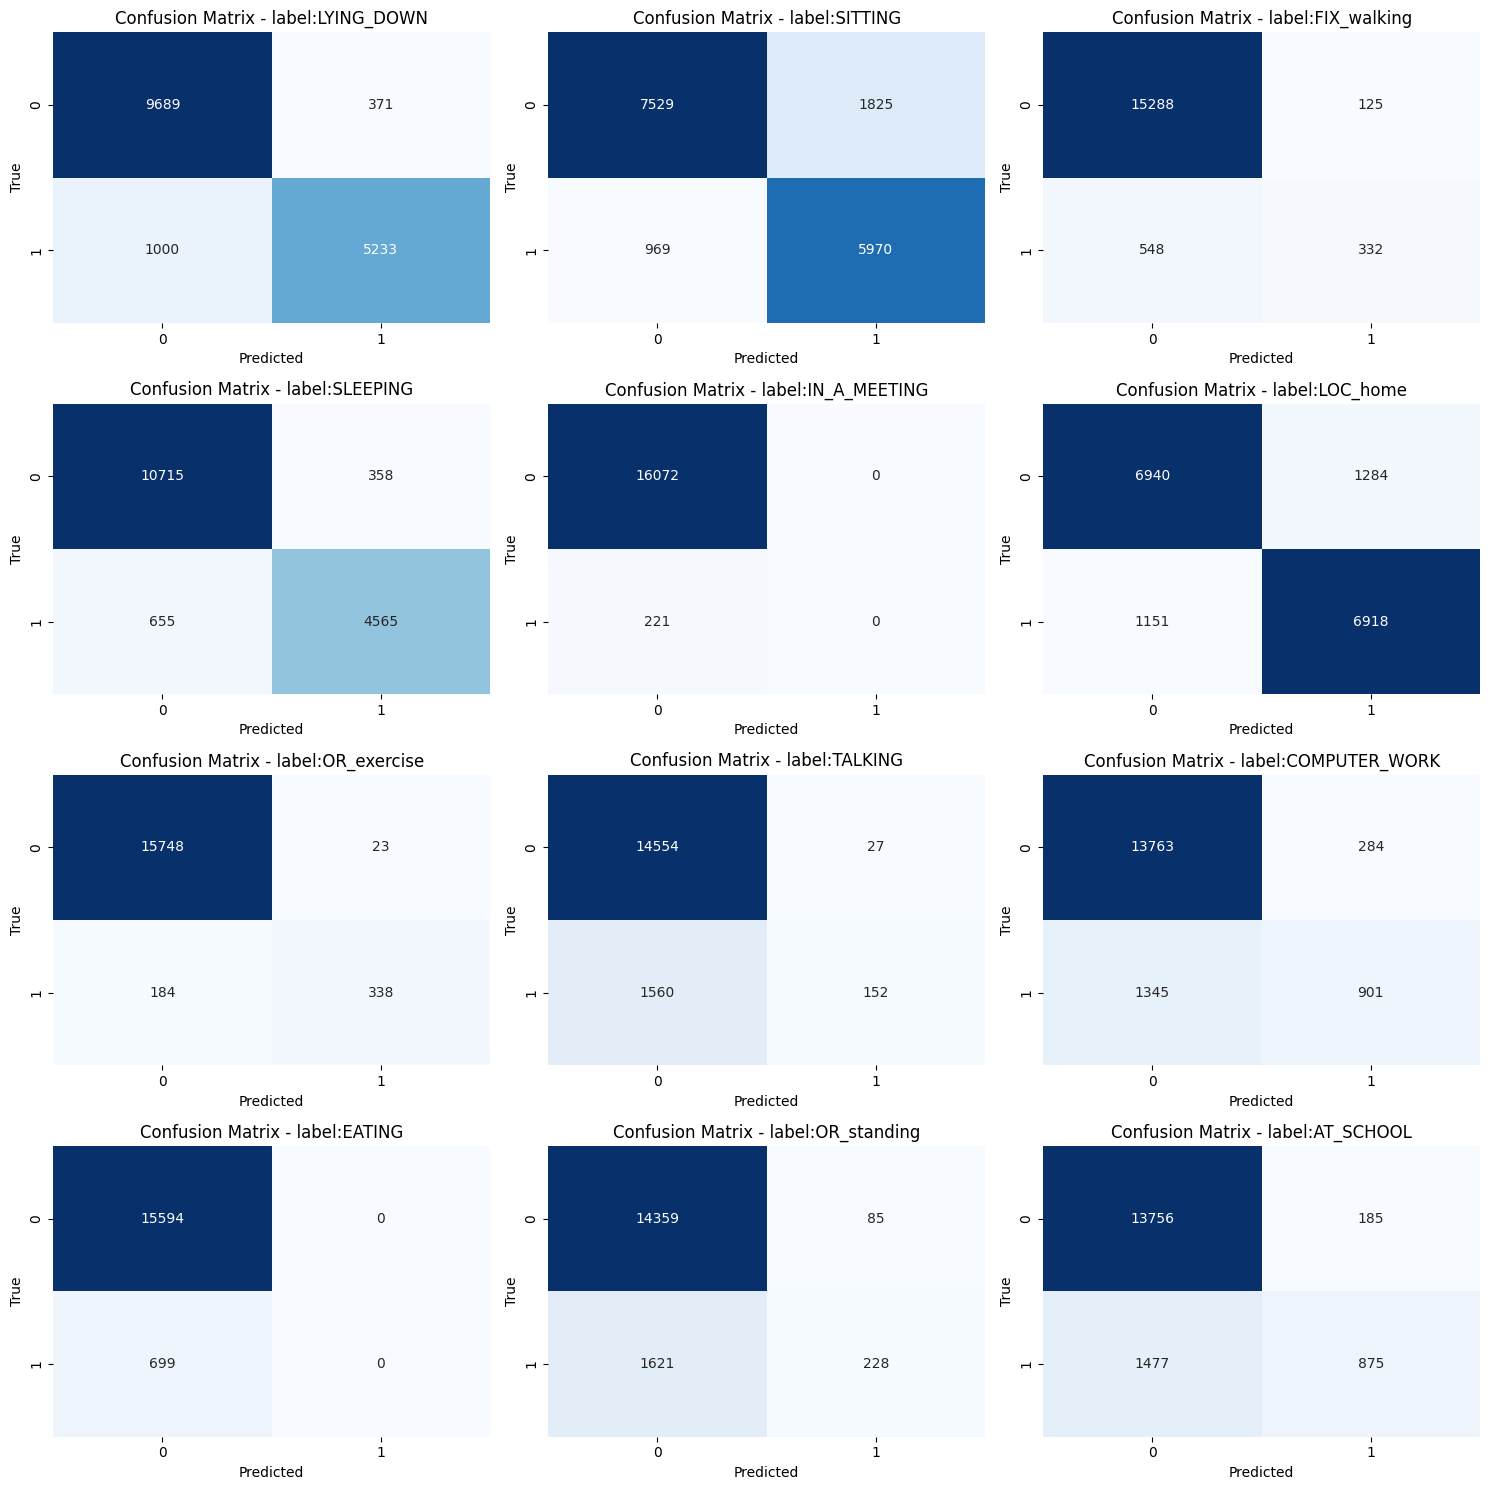

In [135]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

def plot_confusion_matrix(y_test, y_pred, label_columns):
    num_labels = len(label_columns)
    plt.figure(figsize=(15, 15))
    
    for i in range(num_labels):
        cm = confusion_matrix(y_test[:, i], y_pred[:, i])
        plt.subplot((num_labels + 2) // 3, 3, i + 1)  # Arrange subplots in grid
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Confusion Matrix - {label_columns[i]}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
    
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_test, y_pred, label_columns)

Test Accuracy: 0.6988277174246609
Classification Report:
                     precision    recall  f1-score   support

   label:LYING_DOWN       0.99      0.91      0.95      6233
      label:SITTING       0.87      0.92      0.89      6939
  label:FIX_walking       0.80      0.50      0.61       880
     label:SLEEPING       0.99      0.94      0.96      5220
 label:IN_A_MEETING       0.98      0.57      0.72       221
     label:LOC_home       0.94      0.92      0.93      8069
  label:OR_exercise       0.99      0.72      0.84       522
      label:TALKING       0.94      0.53      0.68      1712
label:COMPUTER_WORK       0.96      0.76      0.85      2246
       label:EATING       0.95      0.32      0.48       699
  label:OR_standing       0.92      0.43      0.58      1849
    label:AT_SCHOOL       0.97      0.68      0.80      2352

          micro avg       0.94      0.83      0.88     36942
          macro avg       0.94      0.68      0.77     36942
       weighted avg       

C:\Users\dagin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


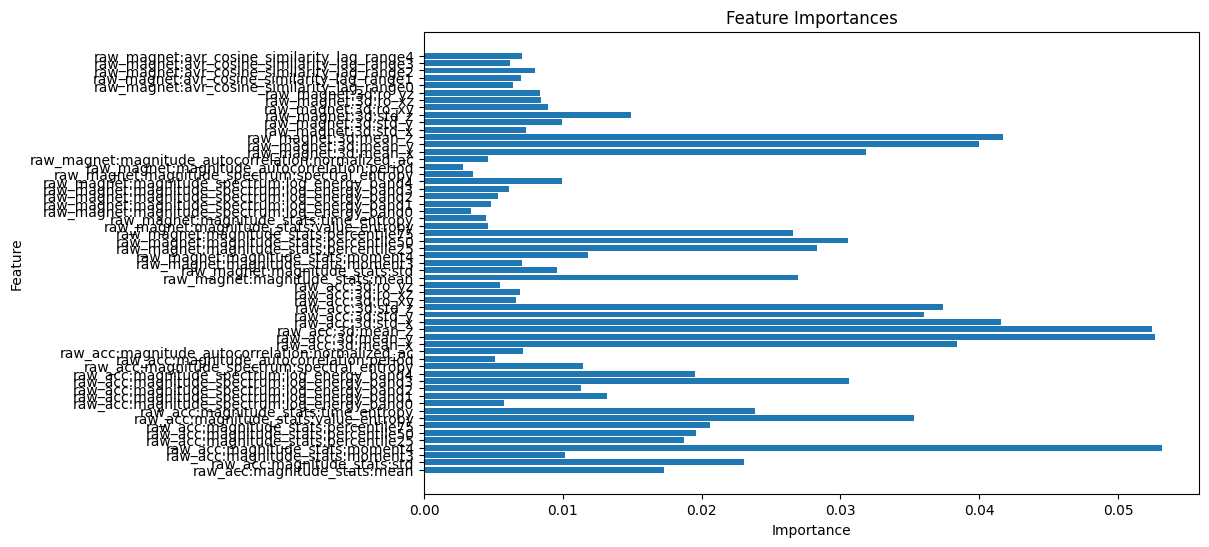

In [136]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Step 1: Split the data into features and labels
features = data[feature_columns].values
labels = data[label_columns].values

# Step 2: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Step 3: Scale the features (optional but can help in some cases)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 4: Create and train the Random Forest model for multi-label classification
rf = RandomForestClassifier(n_estimators=100, random_state=42)
multi_rf = MultiOutputClassifier(rf, n_jobs=-1)  # Use multiple processors
multi_rf.fit(X_train, y_train)

# Step 5: Predict on the test data
y_pred = multi_rf.predict(X_test)

# Step 6: Calculate accuracy and generate classification report
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_columns))

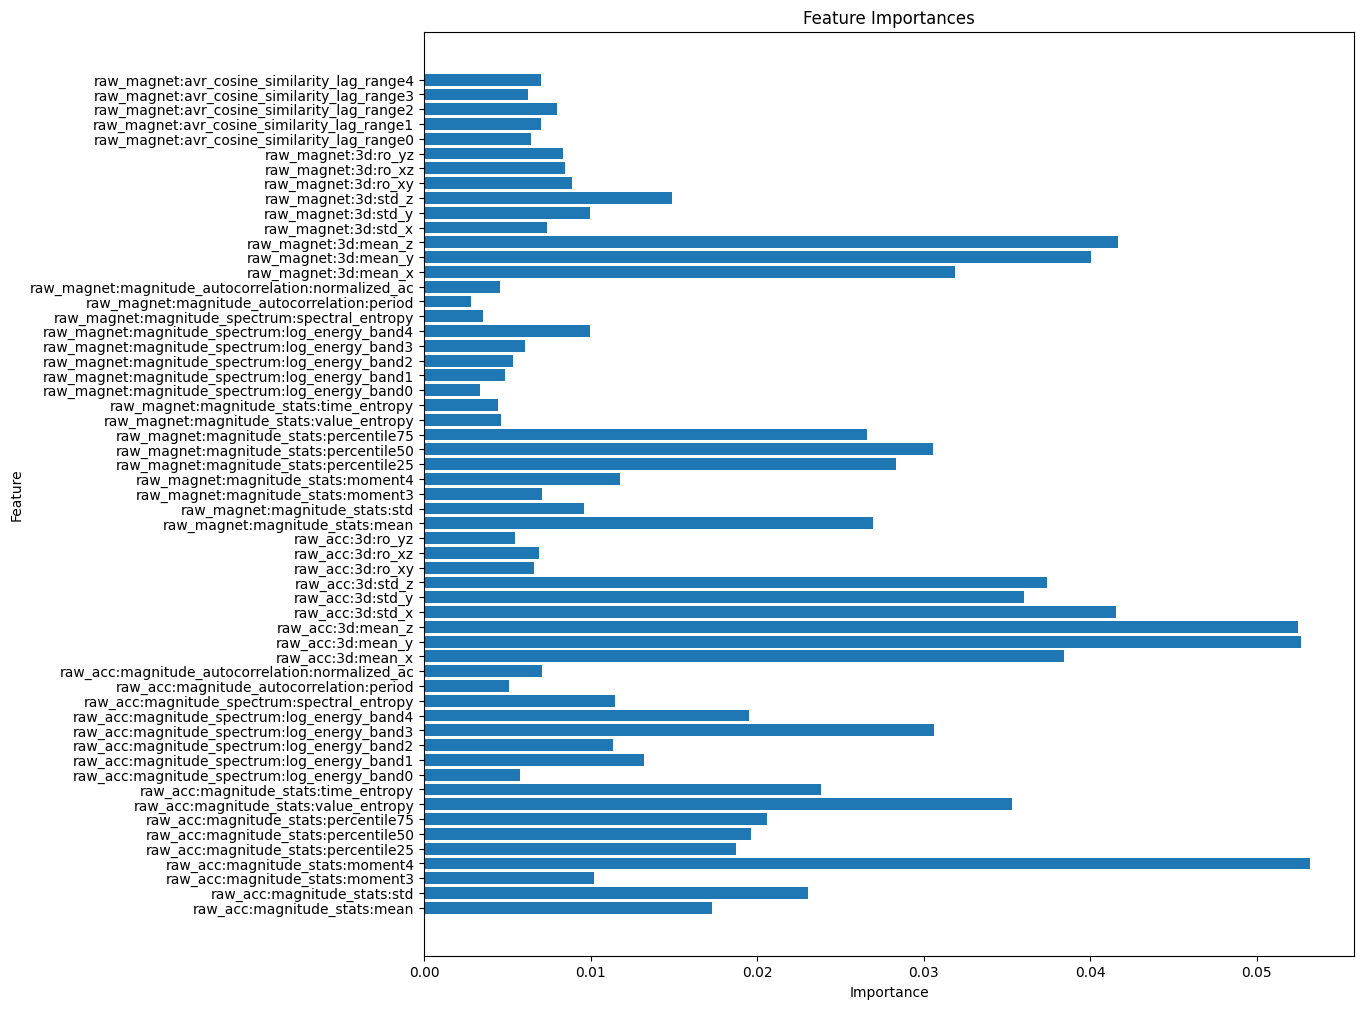

In [141]:
# Step 7: Plot Feature Importances (Optional)
importances = multi_rf.estimators_[0].feature_importances_
plt.figure(figsize=(12, 12))
plt.barh(feature_columns, importances)
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

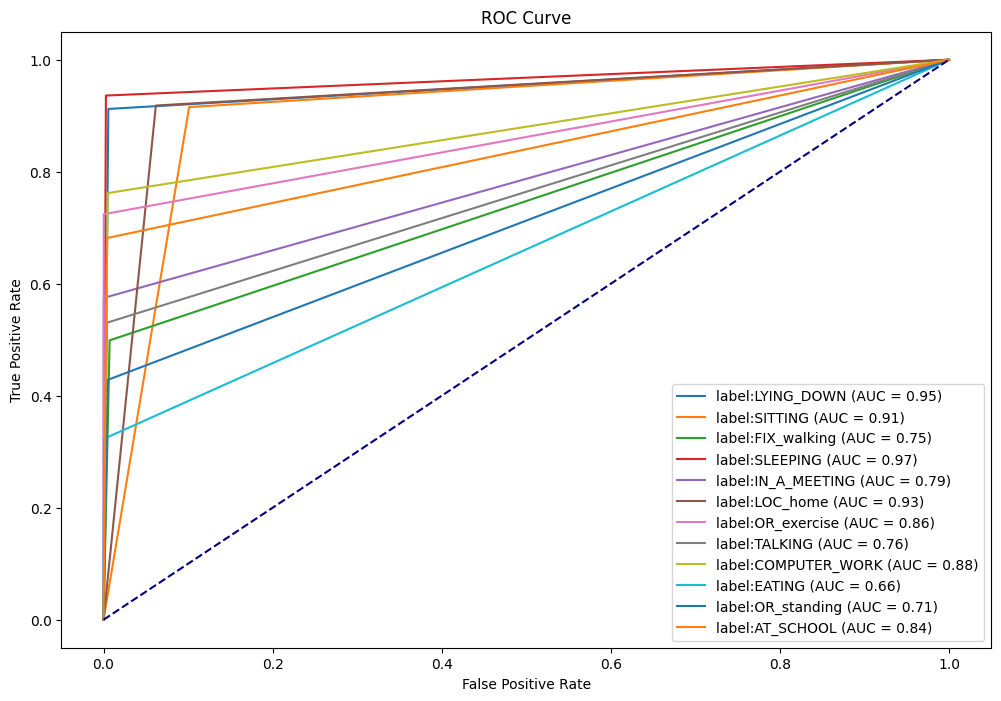

In [137]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curves(y_test, y_pred, label_columns):
    plt.figure(figsize=(12, 8))
    for i in range(len(label_columns)):
        fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{label_columns[i]} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

plot_roc_curves(y_test, y_pred, label_columns)

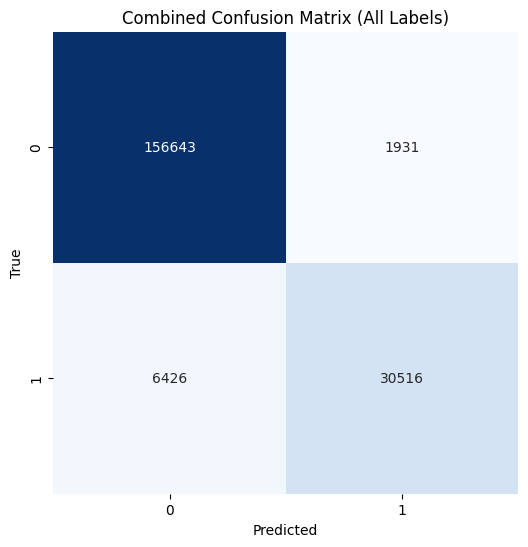

In [138]:
def plot_combined_confusion_matrix(y_test, y_pred, label_columns):
    # Initialize the combined confusion matrix
    combined_cm = np.zeros((2, 2), dtype=int)  # For binary classification per label

    # Sum up confusion matrices for each label
    for i in range(len(label_columns)):
        cm = confusion_matrix(y_test[:, i], y_pred[:, i])
        combined_cm += cm

    # Plot the combined confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(combined_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Combined Confusion Matrix (All Labels)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_combined_confusion_matrix(y_test, y_pred, label_columns)

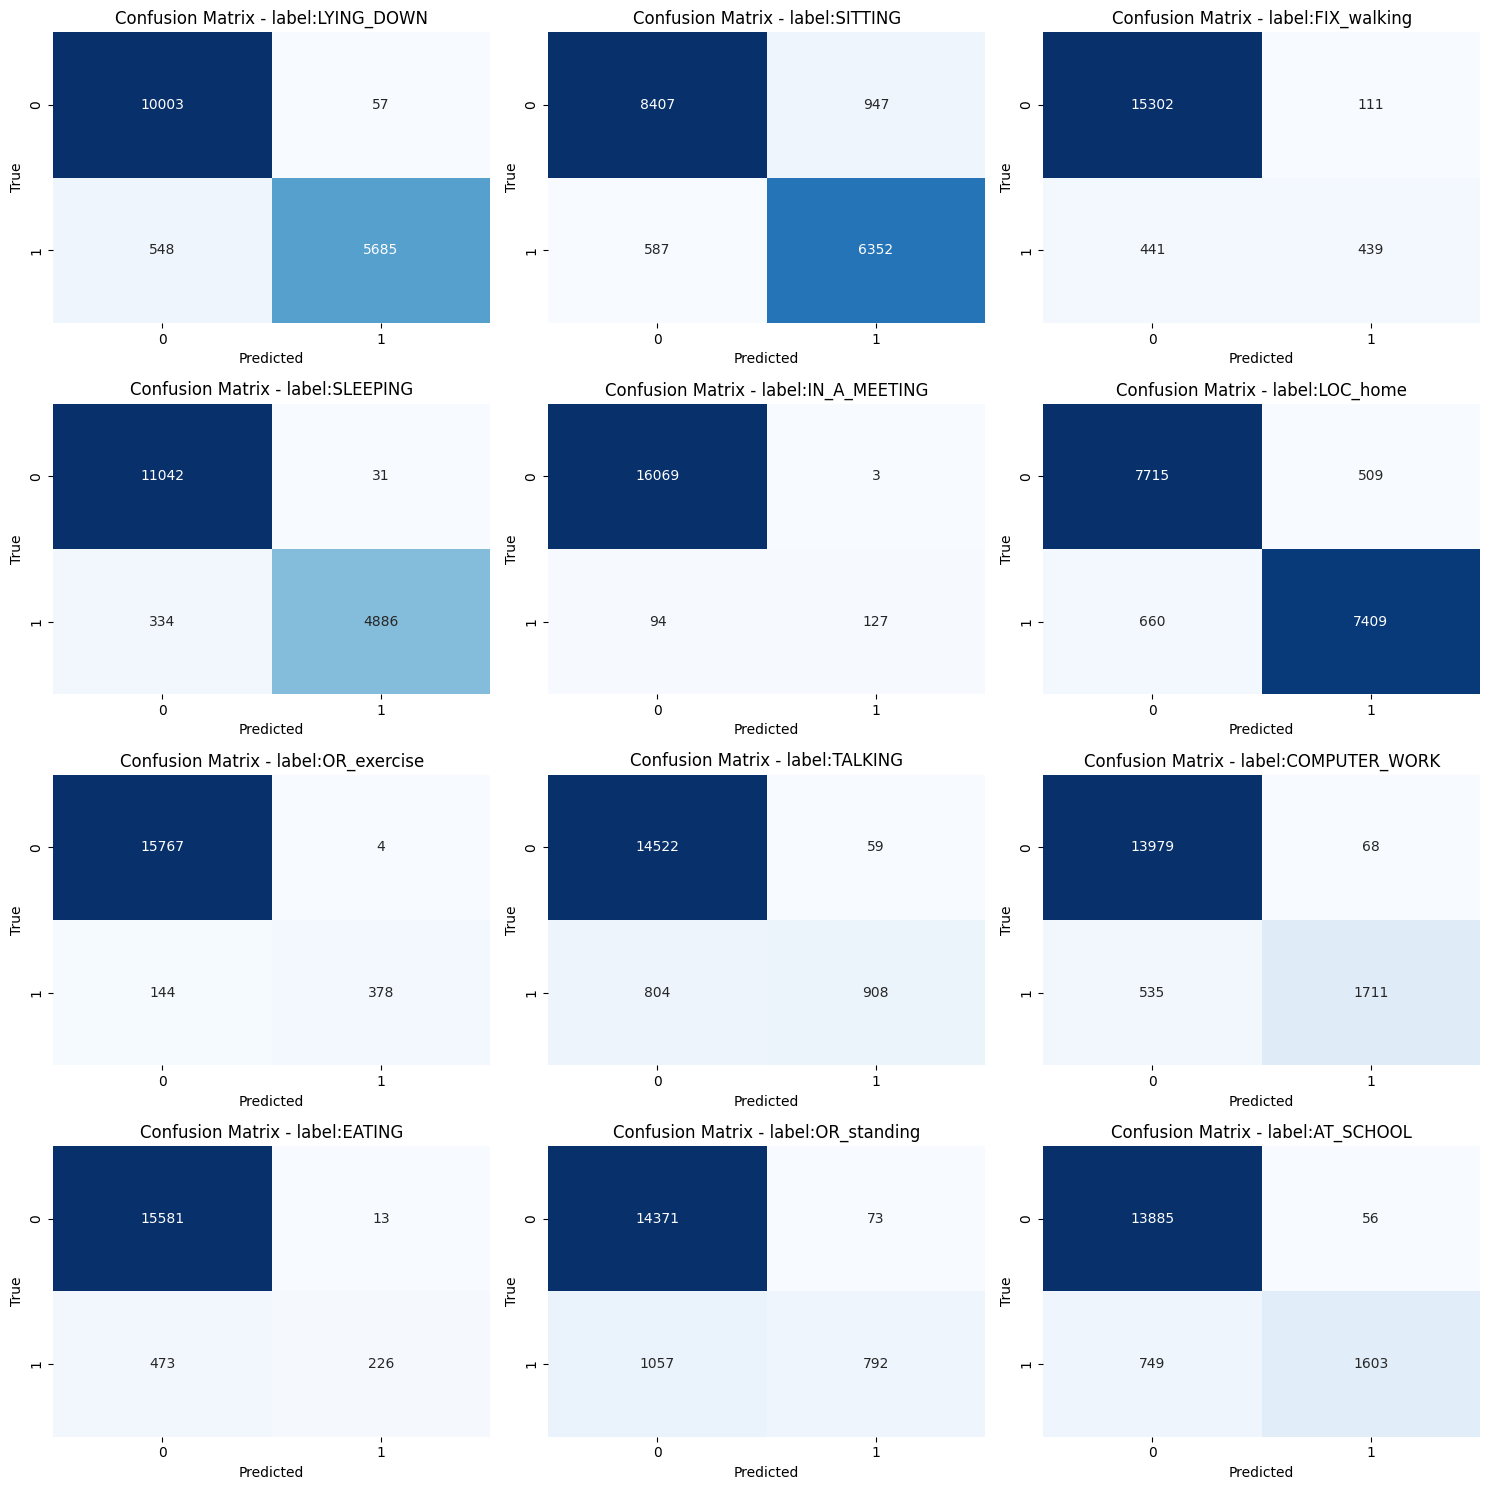

In [139]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

def plot_confusion_matrix(y_test, y_pred, label_columns):
    num_labels = len(label_columns)
    plt.figure(figsize=(15, 15))
    
    for i in range(num_labels):
        cm = confusion_matrix(y_test[:, i], y_pred[:, i])
        plt.subplot((num_labels + 2) // 3, 3, i + 1)  # Arrange subplots in grid
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Confusion Matrix - {label_columns[i]}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
    
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_test, y_pred, label_columns)